In [1]:
import cv2
import audioread
import logging
import os
import random
import time
import warnings

import librosa
import numpy as np
import pandas as pd
import soundfile as sf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

from contextlib import contextmanager
from pathlib import Path
from typing import Optional

# from fastprogress import progress_bar
from sklearn.metrics import f1_score
from torchvision import models
import yaml

import taggle
import matplotlib.pyplot as plt
from ipywidgets import interact
import librosa.display 
%matplotlib inline

In [2]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
    
    
def get_logger(out_file=None):
    logger = logging.getLogger()
    formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
    logger.handlers = []
    logger.setLevel(logging.INFO)

    handler = logging.StreamHandler()
    handler.setFormatter(formatter)
    handler.setLevel(logging.INFO)
    logger.addHandler(handler)

    if out_file is not None:
        fh = logging.FileHandler(out_file)
        fh.setFormatter(formatter)
        fh.setLevel(logging.INFO)
        logger.addHandler(fh)
    logger.info("logger set up")
    return logger
    
@contextmanager
def timer(name: str, logger: Optional[logging.Logger] = None):
    t0 = time.time()
    msg = f"[{name}] start"
    if logger is None:
        print(msg)
    else:
        logger.info(msg)
    yield

    msg = f"[{name}] done in {time.time() - t0:.2f} s"
    if logger is None:
        print(msg)
    else:
        logger.info(msg)
        
logger = get_logger("main.log")
set_seed(2020)

TARGET_SR = 32000

2020-08-31 01:12:12,802 - INFO - logger set up


In [3]:
configs = ["resnest50f_bce_baseline"]


In [4]:
import pandas as pd

In [5]:
train_pl = pd.read_csv("../input/birdsong-recognition/train_pl.csv", index_col=0)

In [6]:
train_pl

,rating,playback_used,ebird_code,channels,date,pitch,duration,filename,speed,species,...,primary_label,longitude,length,time,recordist,license,resampled_sampling_rate,resampled_filename,resampled_channels,pseudo_label_path
0,3.5,no,aldfly,2 (stereo),2013-05-30,increasing,71,XC135883.mp3,level,Alder Flycatcher,...,Empidonax alnorum_Alder Flycatcher,-81.4814,0-3(s),10:30,Guy McGrane,Creative Commons Attribution-NonCommercial-Sha...,32000,XC135883.wav,1 (mono),/root/ml_environment/projects/Kosei-Line/birds...
1,5.0,no,aldfly,2 (stereo),2008-07-02,Not specified,19,XC142065.mp3,Not specified,Alder Flycatcher,...,Empidonax alnorum_Alder Flycatcher,-68.9242,Not specified,06:00,Paul Driver,Creative Commons Attribution-NonCommercial-Sha...,32000,XC142065.wav,1 (mono),/root/ml_environment/projects/Kosei-Line/birds...
2,3.5,no,aldfly,1 (mono),2012-06-07,Not specified,58,XC167789.mp3,Not specified,Alder Flycatcher,...,Empidonax alnorum_Alder Flycatcher,-67.1944,Not specified,06:17,Paul Marvin,Creative Commons Attribution-NonCommercial-Sha...,32000,XC167789.wav,1 (mono),/root/ml_environment/projects/Kosei-Line/birds...
3,3.5,NaN,aldfly,1 (mono),2007-05-20,increasing,23,XC16967.mp3,level,Alder Flycatcher,...,Empidonax alnorum_Alder Flycatcher,-82.5928,0-3(s),?,Allen T. Chartier,Creative Commons Attribution-NonCommercial-Sha...,32000,XC16967.wav,1 (mono),/root/ml_environment/projects/Kosei-Line/birds...
4,3.5,no,aldfly,1 (mono),2014-06-15,level,69,XC189045.mp3,level,Alder Flycatcher,...,Empidonax alnorum_Alder Flycatcher,-123.4621,0-3(s),14:59,Richard E. Webster,Creative Commons Attribution-NonCommercial-Sha...,32000,XC189045.wav,1 (mono),/root/ml_environment/projects/Kosei-Line/birds...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21370,4.5,no,yetvir,2 (stereo),2016-11-25,Not specified,2,XC384645.mp3,level,Yellow-throated Vireo,...,Vireo flavifrons_Yellow-throated Vireo,-87.1362,0-3(s),06:00,Orlando Jarquín G.,Creative Commons Attribution-NonCommercial-Sha...,32000,XC384645.wav,1 (mono),/root/ml_environment/projects/Kosei-Line/birds...
21371,4.5,no,yetvir,1 (mono),2018-05-05,both,40,XC417452.mp3,both,Yellow-throated Vireo,...,Vireo flavifrons_Yellow-throated Vireo,-83.1429,0-3(s),07:50,Sue Riffe,Creative Commons Attribution-NonCommercial-Sha...,32000,XC417452.wav,1 (mono),/root/ml_environment/projects/Kosei-Line/birds...
21372,3.5,no,yetvir,2 (stereo),2018-06-10,Not specified,100,XC467630.mp3,Not specified,Yellow-throated Vireo,...,Vireo flavifrons_Yellow-throated Vireo,-73.075,Not specified,08:21,Martin St-Michel,Creative Commons Attribution-NonCommercial-Sha...,32000,XC467630.wav,1 (mono),/root/ml_environment/projects/Kosei-Line/birds...
21373,4.5,no,yetvir,1 (mono),2019-05-15,both,28,XC477608.mp3,level,Yellow-throated Vireo,...,Vireo flavifrons_Yellow-throated Vireo,-84.0131,0-3(s),13:00,Sue Riffe,Creative Commons Attribution-NonCommercial-Sha...,32000,XC477608.wav,1 (mono),/root/ml_environment/projects/Kosei-Line/birds...


In [7]:
BIRD_CODE = {
    'aldfly': 0, 'ameavo': 1, 'amebit': 2, 'amecro': 3, 'amegfi': 4,
    'amekes': 5, 'amepip': 6, 'amered': 7, 'amerob': 8, 'amewig': 9,
    'amewoo': 10, 'amtspa': 11, 'annhum': 12, 'astfly': 13, 'baisan': 14,
    'baleag': 15, 'balori': 16, 'banswa': 17, 'barswa': 18, 'bawwar': 19,
    'belkin1': 20, 'belspa2': 21, 'bewwre': 22, 'bkbcuc': 23, 'bkbmag1': 24,
    'bkbwar': 25, 'bkcchi': 26, 'bkchum': 27, 'bkhgro': 28, 'bkpwar': 29,
    'bktspa': 30, 'blkpho': 31, 'blugrb1': 32, 'blujay': 33, 'bnhcow': 34,
    'boboli': 35, 'bongul': 36, 'brdowl': 37, 'brebla': 38, 'brespa': 39,
    'brncre': 40, 'brnthr': 41, 'brthum': 42, 'brwhaw': 43, 'btbwar': 44,
    'btnwar': 45, 'btywar': 46, 'buffle': 47, 'buggna': 48, 'buhvir': 49,
    'bulori': 50, 'bushti': 51, 'buwtea': 52, 'buwwar': 53, 'cacwre': 54,
    'calgul': 55, 'calqua': 56, 'camwar': 57, 'cangoo': 58, 'canwar': 59,
    'canwre': 60, 'carwre': 61, 'casfin': 62, 'caster1': 63, 'casvir': 64,
    'cedwax': 65, 'chispa': 66, 'chiswi': 67, 'chswar': 68, 'chukar': 69,
    'clanut': 70, 'cliswa': 71, 'comgol': 72, 'comgra': 73, 'comloo': 74,
    'commer': 75, 'comnig': 76, 'comrav': 77, 'comred': 78, 'comter': 79,
    'comyel': 80, 'coohaw': 81, 'coshum': 82, 'cowscj1': 83, 'daejun': 84,
    'doccor': 85, 'dowwoo': 86, 'dusfly': 87, 'eargre': 88, 'easblu': 89,
    'easkin': 90, 'easmea': 91, 'easpho': 92, 'eastow': 93, 'eawpew': 94,
    'eucdov': 95, 'eursta': 96, 'evegro': 97, 'fiespa': 98, 'fiscro': 99,
    'foxspa': 100, 'gadwal': 101, 'gcrfin': 102, 'gnttow': 103, 'gnwtea': 104,
    'gockin': 105, 'gocspa': 106, 'goleag': 107, 'grbher3': 108, 'grcfly': 109,
    'greegr': 110, 'greroa': 111, 'greyel': 112, 'grhowl': 113, 'grnher': 114,
    'grtgra': 115, 'grycat': 116, 'gryfly': 117, 'haiwoo': 118, 'hamfly': 119,
    'hergul': 120, 'herthr': 121, 'hoomer': 122, 'hoowar': 123, 'horgre': 124,
    'horlar': 125, 'houfin': 126, 'houspa': 127, 'houwre': 128, 'indbun': 129,
    'juntit1': 130, 'killde': 131, 'labwoo': 132, 'larspa': 133, 'lazbun': 134,
    'leabit': 135, 'leafly': 136, 'leasan': 137, 'lecthr': 138, 'lesgol': 139,
    'lesnig': 140, 'lesyel': 141, 'lewwoo': 142, 'linspa': 143, 'lobcur': 144,
    'lobdow': 145, 'logshr': 146, 'lotduc': 147, 'louwat': 148, 'macwar': 149,
    'magwar': 150, 'mallar3': 151, 'marwre': 152, 'merlin': 153, 'moublu': 154,
    'mouchi': 155, 'moudov': 156, 'norcar': 157, 'norfli': 158, 'norhar2': 159,
    'normoc': 160, 'norpar': 161, 'norpin': 162, 'norsho': 163, 'norwat': 164,
    'nrwswa': 165, 'nutwoo': 166, 'olsfly': 167, 'orcwar': 168, 'osprey': 169,
    'ovenbi1': 170, 'palwar': 171, 'pasfly': 172, 'pecsan': 173, 'perfal': 174,
    'phaino': 175, 'pibgre': 176, 'pilwoo': 177, 'pingro': 178, 'pinjay': 179,
    'pinsis': 180, 'pinwar': 181, 'plsvir': 182, 'prawar': 183, 'purfin': 184,
    'pygnut': 185, 'rebmer': 186, 'rebnut': 187, 'rebsap': 188, 'rebwoo': 189,
    'redcro': 190, 'redhea': 191, 'reevir1': 192, 'renpha': 193, 'reshaw': 194,
    'rethaw': 195, 'rewbla': 196, 'ribgul': 197, 'rinduc': 198, 'robgro': 199,
    'rocpig': 200, 'rocwre': 201, 'rthhum': 202, 'ruckin': 203, 'rudduc': 204,
    'rufgro': 205, 'rufhum': 206, 'rusbla': 207, 'sagspa1': 208, 'sagthr': 209,
    'savspa': 210, 'saypho': 211, 'scatan': 212, 'scoori': 213, 'semplo': 214,
    'semsan': 215, 'sheowl': 216, 'shshaw': 217, 'snobun': 218, 'snogoo': 219,
    'solsan': 220, 'sonspa': 221, 'sora': 222, 'sposan': 223, 'spotow': 224,
    'stejay': 225, 'swahaw': 226, 'swaspa': 227, 'swathr': 228, 'treswa': 229,
    'truswa': 230, 'tuftit': 231, 'tunswa': 232, 'veery': 233, 'vesspa': 234,
    'vigswa': 235, 'warvir': 236, 'wesblu': 237, 'wesgre': 238, 'weskin': 239,
    'wesmea': 240, 'wessan': 241, 'westan': 242, 'wewpew': 243, 'whbnut': 244,
    'whcspa': 245, 'whfibi': 246, 'whtspa': 247, 'whtswi': 248, 'wilfly': 249,
    'wilsni1': 250, 'wiltur': 251, 'winwre3': 252, 'wlswar': 253, 'wooduc': 254,
    'wooscj2': 255, 'woothr': 256, 'y00475': 257, 'yebfly': 258, 'yebsap': 259,
    'yehbla': 260, 'yelwar': 261, 'yerwar': 262, 'yetvir': 263
}

In [10]:
PRIMARY2CODE ={'Acanthis flammea_Common Redpoll': 'comred',
 "Accipiter cooperii_Cooper's Hawk": 'coohaw',
 'Accipiter striatus_Sharp-shinned Hawk': 'shshaw',
 'Actitis macularius_Spotted Sandpiper': 'sposan',
 'Aechmophorus occidentalis_Western Grebe': 'wesgre',
 'Aeronautes saxatalis_White-throated Swift': 'whtswi',
 'Agelaius phoeniceus_Red-winged Blackbird': 'rewbla',
 'Aix sponsa_Wood Duck': 'wooduc',
 'Alectoris chukar_Chukar': 'chukar',
 'Amphispiza bilineata_Black-throated Sparrow': 'bktspa',
 'Anas acuta_Northern Pintail': 'norpin',
 'Anas crecca_Green-winged Teal': 'gnwtea',
 'Anas platyrhynchos_Mallard': 'mallar3',
 'Anser caerulescens_Snow Goose': 'snogoo',
 'Anthus rubescens_American Pipit': 'amepip',
 'Aphelocoma californica_California Scrub-Jay': 'cowscj1',
 "Aphelocoma woodhouseii_Woodhouse's Scrub-Jay": 'wooscj2',
 'Aquila chrysaetos_Golden Eagle': 'goleag',
 'Archilochus alexandri_Black-chinned Hummingbird': 'bkchum',
 'Archilochus colubris_Ruby-throated Hummingbird': 'rthhum',
 'Ardea alba_Great Egret': 'greegr',
 'Ardea herodias_Great Blue Heron': 'grbher3',
 "Artemisiospiza belli_Bell's Sparrow": 'belspa2',
 'Artemisiospiza nevadensis_Sagebrush Sparrow': 'sagspa1',
 'Asio flammeus_Short-eared Owl': 'sheowl',
 'Aythya americana_Redhead': 'redhea',
 'Aythya collaris_Ring-necked Duck': 'rinduc',
 'Baeolophus bicolor_Tufted Titmouse': 'tuftit',
 'Baeolophus ridgwayi_Juniper Titmouse': 'juntit1',
 'Bombycilla cedrorum_Cedar Waxwing': 'cedwax',
 'Bonasa umbellus_Ruffed Grouse': 'rufgro',
 'Botaurus lentiginosus_American Bittern': 'amebit',
 'Branta canadensis_Canada Goose': 'cangoo',
 'Bubo virginianus_Great Horned Owl': 'grhowl',
 'Bucephala albeola_Bufflehead': 'buffle',
 'Bucephala clangula_Common Goldeneye': 'comgol',
 'Buteo jamaicensis_Red-tailed Hawk': 'rethaw',
 'Buteo lineatus_Red-shouldered Hawk': 'reshaw',
 'Buteo platypterus_Broad-winged Hawk': 'brwhaw',
 "Buteo swainsoni_Swainson's Hawk": 'swahaw',
 'Butorides virescens_Green Heron': 'grnher',
 "Calidris bairdii_Baird's Sandpiper": 'baisan',
 'Calidris mauri_Western Sandpiper': 'wessan',
 'Calidris melanotos_Pectoral Sandpiper': 'pecsan',
 'Calidris minutilla_Least Sandpiper': 'leasan',
 'Calidris pusilla_Semipalmated Sandpiper': 'semsan',
 'Callipepla californica_California Quail': 'calqua',
 "Calypte anna_Anna's Hummingbird": 'annhum',
 "Calypte costae_Costa's Hummingbird": 'coshum',
 'Campylorhynchus brunneicapillus_Cactus Wren': 'cacwre',
 'Cardellina canadensis_Canada Warbler': 'canwar',
 "Cardellina pusilla_Wilson's Warbler": 'wlswar',
 'Cardinalis cardinalis_Northern Cardinal': 'norcar',
 'Catharus fuscescens_Veery': 'veery',
 'Catharus guttatus_Hermit Thrush': 'herthr',
 "Catharus ustulatus_Swainson's Thrush": 'swathr',
 'Catherpes mexicanus_Canyon Wren': 'canwre',
 'Certhia americana_Brown Creeper': 'brncre',
 'Chaetura pelagica_Chimney Swift': 'chiswi',
 'Charadrius semipalmatus_Semipalmated Plover': 'semplo',
 'Charadrius vociferus_Killdeer': 'killde',
 'Chondestes grammacus_Lark Sparrow': 'larspa',
 'Chordeiles acutipennis_Lesser Nighthawk': 'lesnig',
 'Chordeiles minor_Common Nighthawk': 'comnig',
 "Chroicocephalus philadelphia_Bonaparte's Gull": 'bongul',
 'Circus hudsonius_Northern Harrier': 'norhar2',
 'Cistothorus palustris_Marsh Wren': 'marwre',
 'Clangula hyemalis_Long-tailed Duck': 'lotduc',
 'Coccothraustes vespertinus_Evening Grosbeak': 'evegro',
 'Coccyzus erythropthalmus_Black-billed Cuckoo': 'bkbcuc',
 'Colaptes auratus_Northern Flicker': 'norfli',
 'Columba livia_Rock Pigeon': 'rocpig',
 'Contopus cooperi_Olive-sided Flycatcher': 'olsfly',
 'Contopus sordidulus_Western Wood-Pewee': 'wewpew',
 'Contopus virens_Eastern Wood-Pewee': 'eawpew',
 'Corvus brachyrhynchos_American Crow': 'amecro',
 'Corvus corax_Common Raven': 'comrav',
 'Corvus ossifragus_Fish Crow': 'fiscro',
 'Cyanocitta cristata_Blue Jay': 'blujay',
 "Cyanocitta stelleri_Steller's Jay": 'stejay',
 'Cygnus buccinator_Trumpeter Swan': 'truswa',
 'Cygnus columbianus_Tundra Swan': 'tunswa',
 'Dolichonyx oryzivorus_Bobolink': 'boboli',
 "Dryobates nuttallii_Nuttall's Woodpecker": 'nutwoo',
 'Dryobates pubescens_Downy Woodpecker': 'dowwoo',
 'Dryobates scalaris_Ladder-backed Woodpecker': 'labwoo',
 'Dryobates villosus_Hairy Woodpecker': 'haiwoo',
 'Dryocopus pileatus_Pileated Woodpecker': 'pilwoo',
 'Dumetella carolinensis_Gray Catbird': 'grycat',
 'Empidonax alnorum_Alder Flycatcher': 'aldfly',
 'Empidonax difficilis_Pacific-slope Flycatcher': 'pasfly',
 'Empidonax flaviventris_Yellow-bellied Flycatcher': 'yebfly',
 "Empidonax hammondii_Hammond's Flycatcher": 'hamfly',
 'Empidonax minimus_Least Flycatcher': 'leafly',
 'Empidonax oberholseri_Dusky Flycatcher': 'dusfly',
 'Empidonax traillii_Willow Flycatcher': 'wilfly',
 'Empidonax wrightii_Gray Flycatcher': 'gryfly',
 'Eremophila alpestris_Horned Lark': 'horlar',
 'Euphagus carolinus_Rusty Blackbird': 'rusbla',
 "Euphagus cyanocephalus_Brewer's Blackbird": 'brebla',
 'Falco columbarius_Merlin': 'merlin',
 'Falco peregrinus_Peregrine Falcon': 'perfal',
 'Falco sparverius_American Kestrel': 'amekes',
 'Fulica americana_American Coot': 'y00475',
 "Gallinago delicata_Wilson's Snipe": 'wilsni1',
 'Gavia immer_Common Loon': 'comloo',
 'Geococcyx californianus_Greater Roadrunner': 'greroa',
 "Geothlypis tolmiei_MacGillivray's Warbler": 'macwar',
 'Geothlypis trichas_Common Yellowthroat': 'comyel',
 'Gymnorhinus cyanocephalus_Pinyon Jay': 'pinjay',
 "Haemorhous cassinii_Cassin's Finch": 'casfin',
 'Haemorhous mexicanus_House Finch': 'houfin',
 'Haemorhous purpureus_Purple Finch': 'purfin',
 'Haliaeetus leucocephalus_Bald Eagle': 'baleag',
 'Hirundo rustica_Barn Swallow': 'barswa',
 'Hydroprogne caspia_Caspian Tern': 'caster1',
 'Hylocichla mustelina_Wood Thrush': 'woothr',
 "Icterus bullockii_Bullock's Oriole": 'bulori',
 'Icterus galbula_Baltimore Oriole': 'balori',
 "Icterus parisorum_Scott's Oriole": 'scoori',
 'Ixobrychus exilis_Least Bittern': 'leabit',
 'Junco hyemalis_Dark-eyed Junco': 'daejun',
 'Lanius ludovicianus_Loggerhead Shrike': 'logshr',
 'Larus argentatus_Herring Gull': 'hergul',
 'Larus californicus_California Gull': 'calgul',
 'Larus delawarensis_Ring-billed Gull': 'ribgul',
 'Leiothlypis celata_Orange-crowned Warbler': 'orcwar',
 'Leucosticte tephrocotis_Gray-crowned Rosy-Finch': 'gcrfin',
 'Limnodromus scolopaceus_Long-billed Dowitcher': 'lobdow',
 'Lophodytes cucullatus_Hooded Merganser': 'hoomer',
 'Loxia curvirostra_Red Crossbill': 'redcro',
 'Mareca americana_American Wigeon': 'amewig',
 'Mareca strepera_Gadwall': 'gadwal',
 'Megaceryle alcyon_Belted Kingfisher': 'belkin1',
 'Melanerpes carolinus_Red-bellied Woodpecker': 'rebwoo',
 "Melanerpes lewis_Lewis's Woodpecker": 'lewwoo',
 'Meleagris gallopavo_Wild Turkey': 'wiltur',
 'Melospiza georgiana_Swamp Sparrow': 'swaspa',
 "Melospiza lincolnii_Lincoln's Sparrow": 'linspa',
 'Melospiza melodia_Song Sparrow': 'sonspa',
 'Mergus merganser_Common Merganser': 'commer',
 'Mergus serrator_Red-breasted Merganser': 'rebmer',
 'Mimus polyglottos_Northern Mockingbird': 'normoc',
 'Mniotilta varia_Black-and-white Warbler': 'bawwar',
 'Molothrus ater_Brown-headed Cowbird': 'bnhcow',
 'Myiarchus cinerascens_Ash-throated Flycatcher': 'astfly',
 'Myiarchus crinitus_Great Crested Flycatcher': 'grcfly',
 "Nucifraga columbiana_Clark's Nutcracker": 'clanut',
 'Numenius americanus_Long-billed Curlew': 'lobcur',
 'Oreoscoptes montanus_Sage Thrasher': 'sagthr',
 'Oxyura jamaicensis_Ruddy Duck': 'rudduc',
 'Pandion haliaetus_Osprey': 'osprey',
 'Parkesia motacilla_Louisiana Waterthrush': 'louwat',
 'Parkesia noveboracensis_Northern Waterthrush': 'norwat',
 'Passer domesticus_House Sparrow': 'houspa',
 'Passerculus sandwichensis_Savannah Sparrow': 'savspa',
 'Passerella iliaca_Fox Sparrow': 'foxspa',
 'Passerina amoena_Lazuli Bunting': 'lazbun',
 'Passerina caerulea_Blue Grosbeak': 'blugrb1',
 'Passerina cyanea_Indigo Bunting': 'indbun',
 'Petrochelidon pyrrhonota_Cliff Swallow': 'cliswa',
 'Phainopepla nitens_Phainopepla': 'phaino',
 'Phalacrocorax auritus_Double-crested Cormorant': 'doccor',
 'Phalaropus lobatus_Red-necked Phalarope': 'renpha',
 'Pheucticus ludovicianus_Rose-breasted Grosbeak': 'robgro',
 'Pheucticus melanocephalus_Black-headed Grosbeak': 'bkhgro',
 'Pica hudsonia_Black-billed Magpie': 'bkbmag1',
 'Pinicola enucleator_Pine Grosbeak': 'pingro',
 'Pipilo chlorurus_Green-tailed Towhee': 'gnttow',
 'Pipilo erythrophthalmus_Eastern Towhee': 'eastow',
 'Pipilo maculatus_Spotted Towhee': 'spotow',
 'Piranga ludoviciana_Western Tanager': 'westan',
 'Piranga olivacea_Scarlet Tanager': 'scatan',
 'Plectrophenax nivalis_Snow Bunting': 'snobun',
 'Plegadis chihi_White-faced Ibis': 'whfibi',
 'Podiceps auritus_Horned Grebe': 'horgre',
 'Podiceps nigricollis_Eared Grebe': 'eargre',
 'Podilymbus podiceps_Pied-billed Grebe': 'pibgre',
 'Poecile atricapillus_Black-capped Chickadee': 'bkcchi',
 'Poecile gambeli_Mountain Chickadee': 'mouchi',
 'Polioptila caerulea_Blue-gray Gnatcatcher': 'buggna',
 'Pooecetes gramineus_Vesper Sparrow': 'vesspa',
 'Porzana carolina_Sora': 'sora',
 'Psaltriparus minimus_Bushtit': 'bushti',
 'Quiscalus mexicanus_Great-tailed Grackle': 'grtgra',
 'Quiscalus quiscula_Common Grackle': 'comgra',
 'Recurvirostra americana_American Avocet': 'ameavo',
 'Regulus calendula_Ruby-crowned Kinglet': 'ruckin',
 'Regulus satrapa_Golden-crowned Kinglet': 'gockin',
 'Riparia riparia_Bank Swallow': 'banswa',
 'Salpinctes obsoletus_Rock Wren': 'rocwre',
 'Sayornis nigricans_Black Phoebe': 'blkpho',
 'Sayornis phoebe_Eastern Phoebe': 'easpho',
 "Sayornis saya_Say's Phoebe": 'saypho',
 'Scolopax minor_American Woodcock': 'amewoo',
 'Seiurus aurocapilla_Ovenbird': 'ovenbi1',
 'Selasphorus platycercus_Broad-tailed Hummingbird': 'brthum',
 'Selasphorus rufus_Rufous Hummingbird': 'rufhum',
 'Setophaga americana_Northern Parula': 'norpar',
 'Setophaga caerulescens_Black-throated Blue Warbler': 'btbwar',
 'Setophaga citrina_Hooded Warbler': 'hoowar',
 'Setophaga coronata_Yellow-rumped Warbler': 'yerwar',
 'Setophaga discolor_Prairie Warbler': 'prawar',
 'Setophaga fusca_Blackburnian Warbler': 'bkbwar',
 'Setophaga magnolia_Magnolia Warbler': 'magwar',
 'Setophaga nigrescens_Black-throated Gray Warbler': 'btywar',
 'Setophaga palmarum_Palm Warbler': 'palwar',
 'Setophaga pensylvanica_Chestnut-sided Warbler': 'chswar',
 'Setophaga petechia_Yellow Warbler': 'yelwar',
 'Setophaga pinus_Pine Warbler': 'pinwar',
 'Setophaga ruticilla_American Redstart': 'amered',
 'Setophaga striata_Blackpoll Warbler': 'bkpwar',
 'Setophaga tigrina_Cape May Warbler': 'camwar',
 'Setophaga virens_Black-throated Green Warbler': 'btnwar',
 'Sialia currucoides_Mountain Bluebird': 'moublu',
 'Sialia mexicana_Western Bluebird': 'wesblu',
 'Sialia sialis_Eastern Bluebird': 'easblu',
 'Sitta canadensis_Red-breasted Nuthatch': 'rebnut',
 'Sitta carolinensis_White-breasted Nuthatch': 'whbnut',
 'Sitta pygmaea_Pygmy Nuthatch': 'pygnut',
 'Spatula clypeata_Northern Shoveler': 'norsho',
 'Spatula discors_Blue-winged Teal': 'buwtea',
 'Sphyrapicus ruber_Red-breasted Sapsucker': 'rebsap',
 'Sphyrapicus varius_Yellow-bellied Sapsucker': 'yebsap',
 'Spinus pinus_Pine Siskin': 'pinsis',
 'Spinus psaltria_Lesser Goldfinch': 'lesgol',
 'Spinus tristis_American Goldfinch': 'amegfi',
 "Spizella breweri_Brewer's Sparrow": 'brespa',
 'Spizella passerina_Chipping Sparrow': 'chispa',
 'Spizella pusilla_Field Sparrow': 'fiespa',
 'Spizelloides arborea_American Tree Sparrow': 'amtspa',
 'Stelgidopteryx serripennis_Northern Rough-winged Swallow': 'nrwswa',
 'Sterna hirundo_Common Tern': 'comter',
 'Streptopelia decaocto_Eurasian Collared-Dove': 'eucdov',
 'Strix varia_Barred Owl': 'brdowl',
 'Sturnella magna_Eastern Meadowlark': 'easmea',
 'Sturnella neglecta_Western Meadowlark': 'wesmea',
 'Sturnus vulgaris_European Starling': 'eursta',
 'Tachycineta bicolor_Tree Swallow': 'treswa',
 'Tachycineta thalassina_Violet-green Swallow': 'vigswa',
 "Thryomanes bewickii_Bewick's Wren": 'bewwre',
 'Thryothorus ludovicianus_Carolina Wren': 'carwre',
 "Toxostoma lecontei_LeConte's Thrasher": 'lecthr',
 'Toxostoma rufum_Brown Thrasher': 'brnthr',
 'Tringa flavipes_Lesser Yellowlegs': 'lesyel',
 'Tringa melanoleuca_Greater Yellowlegs': 'greyel',
 'Tringa solitaria_Solitary Sandpiper': 'solsan',
 'Troglodytes aedon_House Wren': 'houwre',
 'Troglodytes hiemalis_Winter Wren': 'winwre3',
 'Turdus migratorius_American Robin': 'amerob',
 'Tyrannus tyrannus_Eastern Kingbird': 'easkin',
 'Tyrannus verticalis_Western Kingbird': 'weskin',
 'Vermivora cyanoptera_Blue-winged Warbler': 'buwwar',
 "Vireo cassinii_Cassin's Vireo": 'casvir',
 'Vireo flavifrons_Yellow-throated Vireo': 'yetvir',
 'Vireo gilvus_Warbling Vireo': 'warvir',
 'Vireo olivaceus_Red-eyed Vireo': 'reevir1',
 'Vireo plumbeus_Plumbeous Vireo': 'plsvir',
 'Vireo solitarius_Blue-headed Vireo': 'buhvir',
 'Xanthocephalus xanthocephalus_Yellow-headed Blackbird': 'yehbla',
 'Zenaida macroura_Mourning Dove': 'moudov',
 'Zonotrichia albicollis_White-throated Sparrow': 'whtspa',
 'Zonotrichia atricapilla_Golden-crowned Sparrow': 'gocspa',
 'Zonotrichia leucophrys_White-crowned Sparrow': 'whcspa'}

[80, 212]


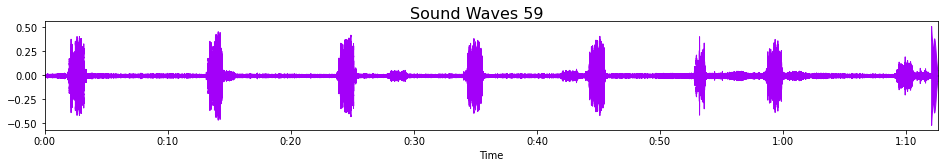

interactive(children=(IntSlider(value=7, description='k', max=14), Output()), _dom_classes=('widget-interact',))

<function __main__.f>

In [16]:
idx = 1007
data_path = "../input/birdsong-recognition/train_audio_resampled_32000"
sample = train_pl.loc[idx, :]
ebird_code = sample["ebird_code"]
wav_name = sample["resampled_filename"]
pseudo_label = np.load(sample["pseudo_label_path"])
audio_sample, sr = librosa.load(os.path.join(data_path, ebird_code, wav_name))

fig, ax = plt.subplots(1, figsize = (16, 2))
fig.suptitle(f'Sound Waves {BIRD_CODE[ebird_code]}', fontsize=16)

librosa.display.waveplot(y = audio_sample, sr = sr, color = "#A300F9")
klen = len(pseudo_label)
sls_2 = []
for sl in sample["secondary_labels"].replace('[', '').replace(']', '').replace("\'", '').replace("\"", '').split(","):
    if sl == "":
        continue
    if sl[0] == " ":
        sl = sl[1:]
    if sl[-1] == " ":
        sl = sl[:-1]
    try:
        sls_2.append(PRIMARY2CODE[sl])
    except: 
        pass
print([BIRD_CODE[i] for i in sls_2])
def f(k):
    fig, ax = plt.subplots(1, figsize = (16, 2))
    width = 0.35
    prob = pseudo_label[k]
    x = np.arange(len(prob))
    plt.bar(x, prob, width)
    plt.ylim(0, 1)
    plt.xticks(list(range(0, 264, 10)))
    plt.show()

interact(f, k=(0,klen-1) )

In [9]:
pseudo_label.shape

(15, 264)